In [105]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

## Auto Encoder
Reference: https://github.com/nlinc1905/Convolutional-Autoencoder-Music-Similarity/blob/master/03_autoencoding_and_tsne.py

### read images

In [58]:
# configuration
VAL_SIZE = 0.1
TEST_SIZE = 0.1
IMG_HEIGHT = 128
IMG_WIDTH = 1291
BATCH_SIZE = 16
# NUM_CHANNELS has to be 3 for "rgb" and 1 for "grayscale"
NUM_CHANNELS = 3
DATA_DIR = "/kaggle/input/train-spectrograms/Train_Spectogram_Images_first_10_percent"

# load the training data set as rgb images
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="training",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# load validation data set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="validation",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 707 files belonging to 7 classes.
Using 693 files for training.
Found 707 files belonging to 7 classes.
Using 14 files for validation.


In [3]:
images = np.array([])
labels =  np.array([])
for x, y in train_ds:
    if len(images)==0:
        images = x.numpy()
    else:
        images = np.concatenate([images, x.numpy()])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [4]:
# scale
images /= 255.

In [5]:
images.shape, labels.shape

((566, 128, 1291, 3), (566,))

### auto encoder

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.decomposition import PCA

In [98]:
latent_dim = 32

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1, 1),padding='valid', activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2), strides=None,padding='valid'),
            layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1),padding='valid', activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2), strides=None,padding='valid'),
            layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1, 1),padding='valid', activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2), strides=None,padding='valid'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        
        self.decoder = tf.keras.Sequential([
          layers.Dense(495744, activation='sigmoid'),
          layers.Reshape((128, 1291, 3))
#             layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
#             layers.Conv2DTranspose(32, kernel_size=3, strides=1, activation='relu', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [99]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(images, images, epochs=15, shuffle=True)
autoencoder.save_weights('/kaggle/working/ae_checkpoint/')

Epoch 1/15
18/18 [==============================] - 93s 5s/step - loss: 0.0313
Epoch 2/15
18/18 [==============================] - 90s 5s/step - loss: 0.0224
Epoch 3/15
18/18 [==============================] - 91s 5s/step - loss: 0.0218
Epoch 4/15
18/18 [==============================] - 89s 5s/step - loss: 0.0213
Epoch 5/15
18/18 [==============================] - 89s 5s/step - loss: 0.0211
Epoch 6/15
18/18 [==============================] - 89s 5s/step - loss: 0.0207
Epoch 7/15
18/18 [==============================] - 90s 5s/step - loss: 0.0205
Epoch 8/15
18/18 [==============================] - 90s 5s/step - loss: 0.0205
Epoch 9/15
18/18 [==============================] - 97s 5s/step - loss: 0.0196
Epoch 10/15
18/18 [==============================] - 91s 5s/step - loss: 0.0188
Epoch 11/15
18/18 [==============================] - 90s 5s/step - loss: 0.0160
Epoch 12/15
18/18 [==============================] - 90s 5s/step - loss: 0.0152
Epoch 13/15
18/18 [==============================

In [ ]:
# autoencoder = Autoencoder(latent_dim)
# autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
# autoencoder.load_weights("/kaggle/working/ae_checkpoint/")

### evaluation

In [100]:
encoded = autoencoder.encoder.predict(images)

18/18 [==============================] - 22s 1s/step


In [101]:
encoded[0]

array([ 0.       ,  0.       ,  6.8252554,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  6.3267717,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  4.3040404,
        0.       ,  0.       ,  0.       ,  9.468631 ,  0.       ,
        0.       , 32.44614  ,  0.       ,  0.       ,  0.       ,
        0.       , 17.14059  ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ], dtype=float32)

In [82]:
train_ds.class_names

['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'Pop',
 'Rock']

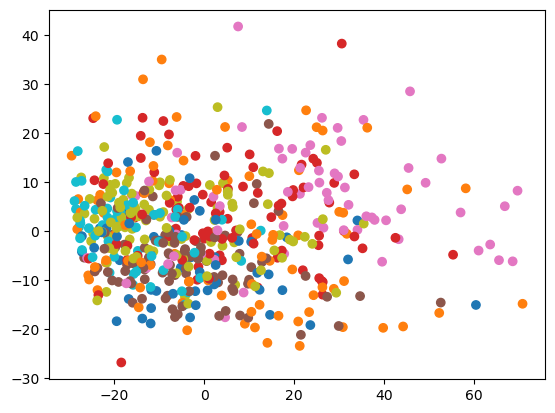

In [102]:
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded)
scatter = plt.scatter(encoded_pca[:,0], encoded_pca[:,1], c=labels, cmap="tab10")
# plt.legend(*scatter.legend_elements())

In [103]:
decoded = autoencoder.decoder.predict(encoded)

18/18 [==============================] - 1s 53ms/step


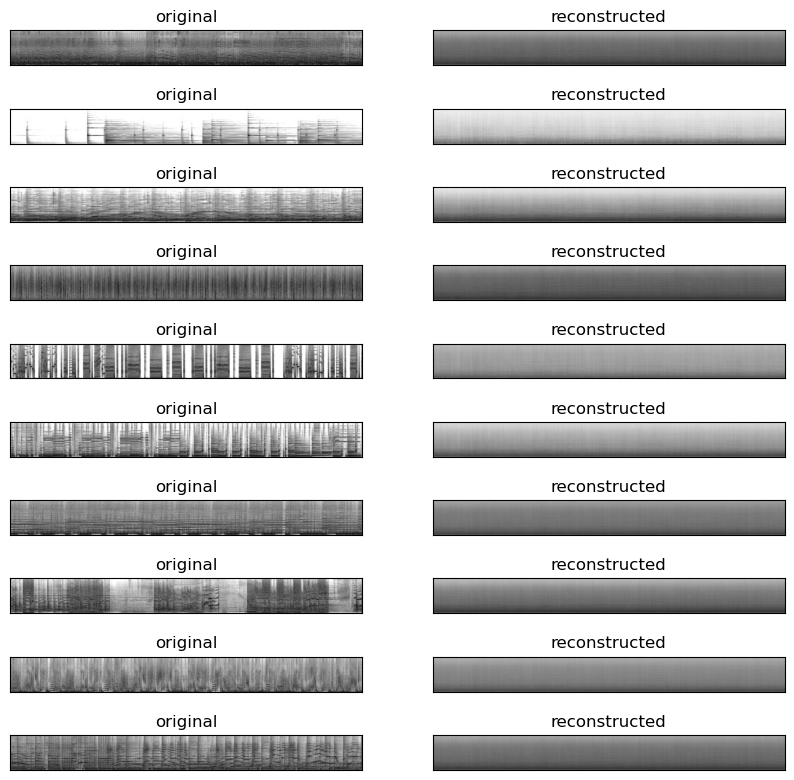

In [104]:
n = 10
plt.figure(figsize=(10, 10))
for i in range(n):
    # display original
    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 2, 2*i+2)
    plt.imshow(decoded[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()